<a href="https://colab.research.google.com/github/fernassouza/Data-Science/blob/master/Projeto_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Data Science**
***by Fernando Souza***

**CHURN PREDICITON**

Churn é uma métrica usada para indicar o quanto sua empresa perdeu de receita ou clientes.

É de extrema importância entender o motivo de abandono dos clientes para conquistar um crescimento saudável. Com o crescimento do modelo de negócios por assinatura, o Churn se tornou mais conhecido.

Essa métrica está dentro de um conjunto de serviços conhecido como Saas(software as a service). Trata-se de um modelo de licenciamento e entrega de software, onde a empresa fornecedora é responsável pela infraestrutura necessária (servidores, conectividade, segurança, atualizações, etc.).


**Aquisição dos Dados**

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíveis, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# importando as bibliotecas
!pip install scikit-plot -q

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report
from scikitplot.metrics import plot_confusion_matrix
from statistics import mean

# importando o dataset
df = pd.read_csv('https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Como podemos ver nas primeiras 5 linhas do dataset, existe informações importantes que nos ajudarão a entender melhor o problema e na construção do modelo para prever possíveis  desistências futuras.

Abaixo será verificado o tamanho do dataset.

In [2]:
# tamanho do dataset
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


Será verificado se existem dados ausentes, os nomes das colunas, os total de valores únicos por coluna e o tipo de cada variável.

In [3]:
# dados ausente, nomes das feature, valores únicos e tipos dos objetos
print(f'Dados ausente = {df.isnull().sum().values.sum()}\n')
print(df.isnull().sum() / df.shape[0])
print(f'\nNome das features:\n {df.columns.values}')
print(f'\nValores únicos por coluna:\n{df.nunique()}')
print(f'\nTipos de variáveis por coluna:\n{df.dtypes}')

Dados ausente = 0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nome das features:
 ['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos por coluna:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Depen

Como verificado acima, algumas observações são necessárias:
  * A variável alvo do dataset é a `Churn`;
  * Não foram identificado dados faltantes no dataset;
  * A coluna `costumerID` não tem relevância para a análise, pois trata-se de um código da operadora;
  * A coluna `TotalCharges` está identificada como um objeto do tipo string, mas a mesma contém números.

  A seguir iremos realizar essas tratativas necessárias.

In [4]:
# gerando uma cópia do dataset
df_2 = df.copy()

# remover coluna costumerID
df_2.drop("customerID", axis=1, inplace=True)

# converter TotalCharges em float
def converter_str_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan

df_2.TotalCharges = df_2.TotalCharges.apply(converter_str_float)

# verificar dados ausentes após converão
print("Dados ausentes encontrados em 'TotalCharges' :\t{}\n".format(df_2["TotalCharges"].isnull().sum()))

# preencher dados ausentes com mediana
TCmedian = df_2.TotalCharges.median()
df_2.TotalCharges.fillna(TCmedian, inplace=True)

Dados ausentes encontrados em 'TotalCharges' :	11



Ao tentar a princípio converter a coluna `TotalCharges` em float, foi apresentado um erro o que não permitiu a conversão.

O que foi proposto em uma função foi a de converter os possíveis e preencher com `nan` o restante e depois substitui-los pela mediana da coluna.

Deixando no final toda a coluna `TotalCharges` com valor numérico.

Mesmo o dataset sendo na maioria de variáveis não numéricas ainda sim podemos ver a descrição do mesmo e iniciar a verificação de `Outliers`.

In [5]:
df_2.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


A seguir será verificado se existem `Outliers` (pontos fora da curva), que podem atrapalhar no desempenho do modelo de machine learning.

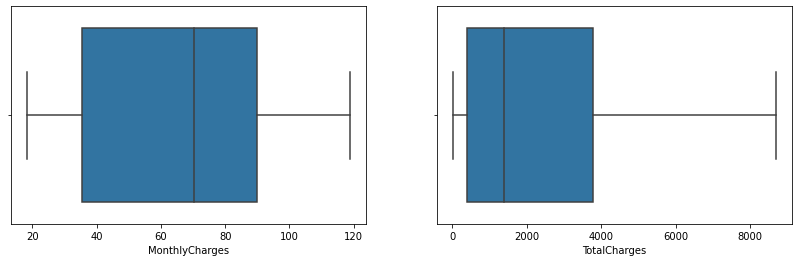

In [6]:
# boxplot para verificar outliers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.boxplot(df_2.MonthlyCharges, ax=ax[0])
sns.boxplot(df_2.TotalCharges, ax=ax[1])

plt.show()

Como é possível ver no boxplot acima, não existem `Outliers` nesse dataset.

Serão verificados os gráficos de algumas variáveis que aparentam ser de importância para tratar a desistência ou não de clientes.

Tais variáveis como: `tenure`, `Contract`, `PhoneService`, `StreamingTV`, `StreamingMovies` em relação ao `Churn`.

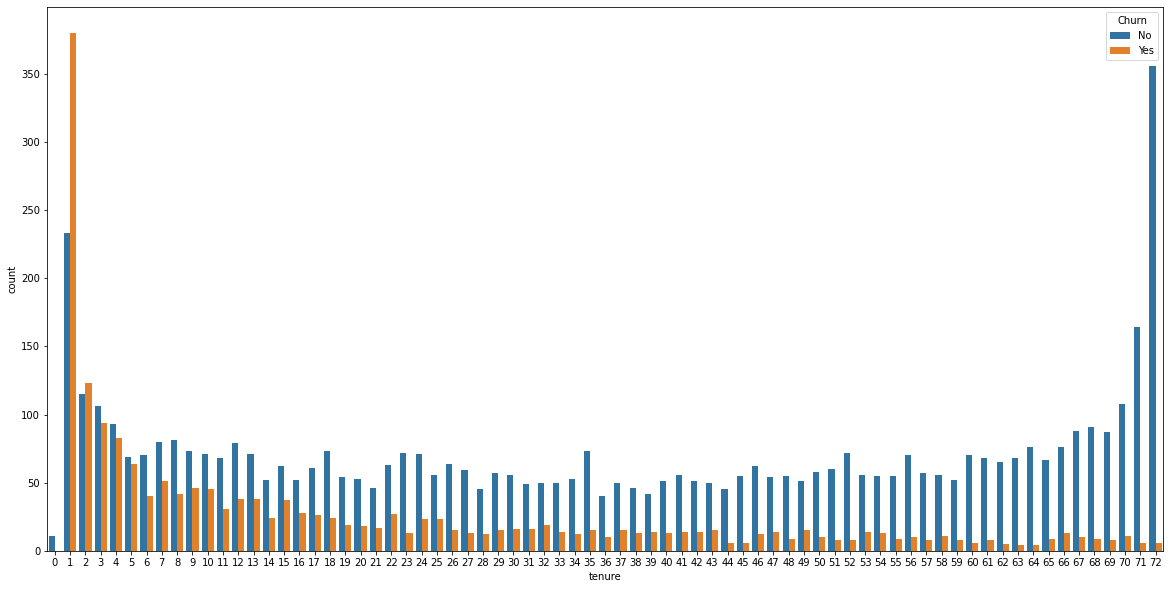

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='tenure', hue='Churn', data=df_2)
sns.set(style='darkgrid')
sns.set_palette('hls', 3)

No gráfico acima é possível  ver que a desistência vai diminuindo conforme o tempo vai aumentando.

O maior número de desistências ocorre no primeiro mês de contrato e vai decaindo.

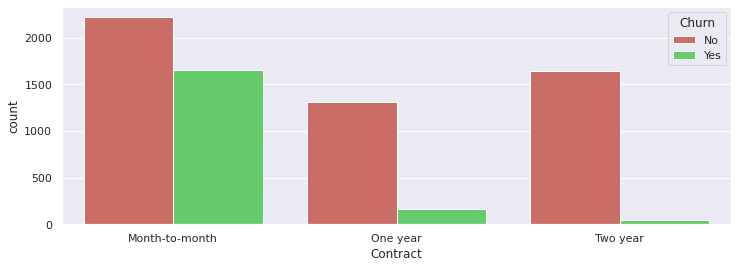

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x='Contract', hue='Churn', data=df_2)
sns.set(style='darkgrid')
sns.set_palette('hls', 3)

No gráfico acima é possível  ver que a maior desistência está nos contratos mês a mês.

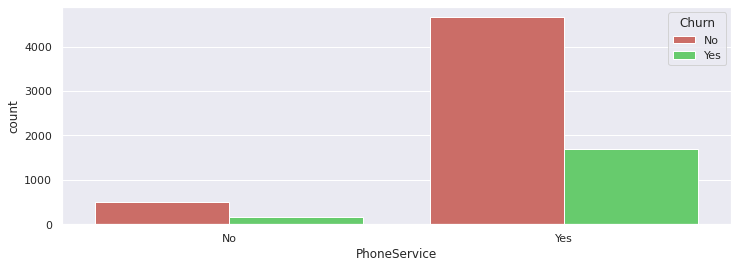

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x='PhoneService', hue='Churn', data=df_2)
sns.set(style='darkgrid')
sns.set_palette('hls', 3)

Os que possuem serviço de telefonia tem mais tendência a cancelar o contrato.

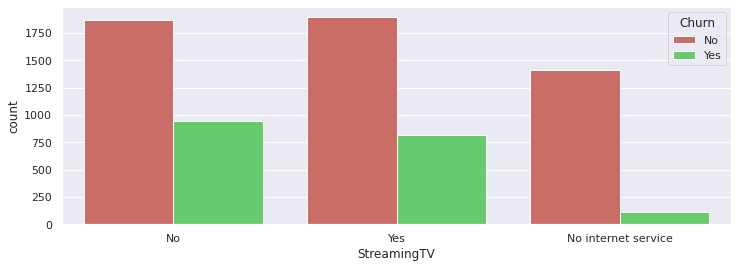

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x='StreamingTV', hue='Churn', data=df_2)
sns.set(style='darkgrid')
sns.set_palette('hls', 3)

No comparativo entre Streaming de TV, os usuários que não possuem o serviço e os que possuem tem uma diferença pequena para desistência.

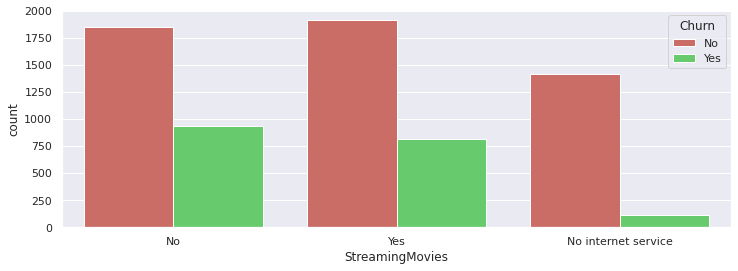

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x='StreamingMovies', hue='Churn', data=df_2)
sns.set(style='darkgrid')
sns.set_palette('hls', 3)

Assim como no Streaming de TV, o Streaming de Filmes, a diferença também é pequena para os que possuem e os que não possuem.

In [12]:
# ver total de entradas da variável alvo
print(df.Churn.value_counts())

No     5174
Yes    1869
Name: Churn, dtype: int64


Como é possível ver acima, existe um desbalanceamento muito grande na variável alvo e o mesmo deverá ser tratado.

**Preparação dos Dados**

Neste ponto será separada as variáveis binárias, numéricas e categóricas e converte-las para numéricas, usando o método LabelEncoder.

É necessário fazer essa conversão pois alguns modelos de machine learning não trabalham muito bem com dados de texto.

In [13]:
# pré-processando variáveis
bin_var = df_2.nunique()[df_2.nunique() == 2].keys().tolist()
num_var = [col for col in df_2.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df_2.columns.tolist() if col not in bin_var + num_var]

# copiar dataframe
df_copy = df_2.copy()

# converter binários em númericas
le = LabelEncoder()
for i in bin_var:
    df_copy[i] = le.fit_transform(df_copy[i])

# converter categoricas em númericas
df_copy = pd.get_dummies(df_copy, columns=cat_var)

df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


O resultado após a conversão é uma tabela com diversos 0 e 1.
Com exceção das colunas que já continham números.

Também foi criada uma nova cópia para podermos trabalhar sem mexer na original.

**Separando os dados**

Iremos dividir os dados entre treino e teste para poder treinar o modelo.

In [14]:
# dividindo os dados
X = df_copy.drop('Churn', axis=1)
y = df_copy.Churn

# dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

# padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

**Padronizando os Dados**



Como já foi verificado acima, existe um desbalanceamento dos dados e usaremos o SMOTE para tratá-los.

SMOTE é uma técnica que trabalha selecionando exemplos próximos das features e criando novas para balancear os dados.

Foi usado e SMOTE que aumenta a classe menor e RandonUnderSample que diminui a classe maior, para que elas tenham um balanceamento próximo.

Será feito o balanceamento nos dados de treino.

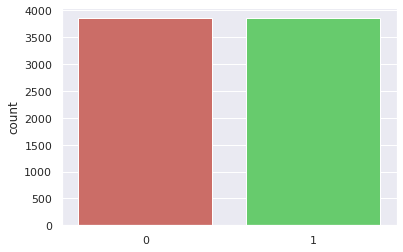

In [15]:
# define pipeline
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transformndo o dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

ax = sns.countplot(x=y_train)

Como é possível ver no gráfico acima, os dados após tratados por SMOTE e RandomUnderSampler ficaram balanceados.

**Modelo de Machine Learninbg**

Para tratar do problema de Churn, será utilizar o modelo de Regressão Logistíca, que é um modelo supervisionado usado para predizer a probabilidade de uma variável alvo. Neste caso a variável Churn.

Criando o modelo de Regressão Logística.

In [16]:
# instanciando e treinando o modelo
model = LogisticRegression().fit(X_train, y_train)

Abaixo será avaliada a acurácia do modelo com os dados de treino.

In [17]:
# avaliando acuracia dos dados de treino
results = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print(f'Acurácia média: {mean * 100:.2f}%')
    print(f'Intervalo de acurácia: {(mean - 2 * dv) * 100:.2f}% ~ {(mean + 2 * dv) * 100:.2f}%')

intervalo(results)

Acurácia média: 78.32%
Intervalo de acurácia: 75.39% ~ 81.26%


Como resultado na acurácia, é possível verificar que está na casa dos 78%.

A seguir será usado o GridSearchCV, que ajuda a achar o melhores hiperparâmetros para modelos de machine learning.

Esse hiperparâmetros serão usados para melhorar o modelo, obtendo assim melhores resultados de predição, no caso do modelo atual.

In [18]:
# usando gridsearchCV para encontrar os melhores parametros para logistic regression
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.9min finished


Best Score:  0.8655436458533632
Best Params:  {'C': 100, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Após o GridSearchCV fazer uma busca ele retorna os resultados a serem adicionados ao modelo.

No caso, foi indicado que os melhores parâmetros foram: {'C': 100, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l1', 'solver': 'saga'}.

Esses parâmetros serão incluídos no modelo a seguir.

O modelo será treinado usando dados de treino, e depois será testado nos dados de testes. Em seguida será feita a predição e avaliação para obter os resultados do modelo.

In [ ]:
# instanciando modelo com melhores parâmetros 
model = LogisticRegression(C=100, class_weight={1:0.4, 0:0.6}, penalty='l1', solver='saga').fit(X_train, y_train)
X_test = scaler.fit_transform(X_test)
y_pred = model.predict(X_test)

Após a predição do modelo, foram tiradas algumas métricas para avaliação.

E também gerada uma matriz de confusão, que é uma maneira de medir o desempenho para um problema de classificação, que neste caso é o se o cliente vai encerrar o contrato ou não.

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1322
           1       0.53      0.67      0.59       439

    accuracy                           0.77      1761
   macro avg       0.71      0.74      0.72      1761
weighted avg       0.79      0.77      0.78      1761



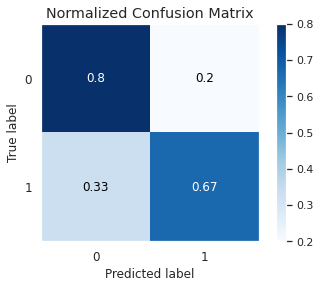

In [20]:
print(classification_report(y_test, y_pred))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Na tabela de classificação pode-se ver que o acurácia foi de 78% nos dados de teste, que significa que ele acertou 78% dos dados que recebeu para avaliar.

A matriz de confusão indica os acertos e erros do modelo.

Lado direito inferior previu corretamente quem iam cancelar, 67%.

Lado esquerdo inferior previu errado quem iam cancelar, 33%.

Lado direito superior previu errado quem não iam cancela, 20%.

Lado esquerdo  superior previu corretamente quem não iam cancelar, 80%.


AxesSubplot(0.125,0.125;0.775x0.755)


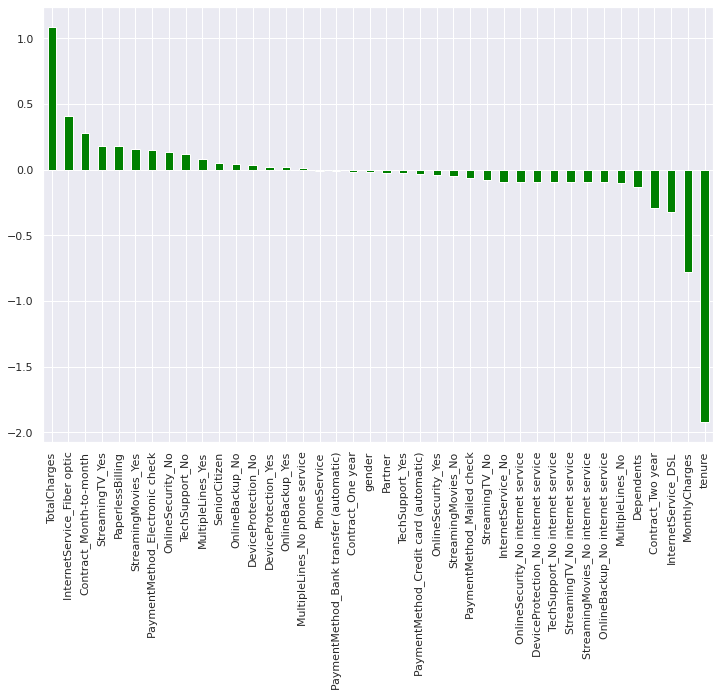

In [21]:
# negativas tendem a 0 (não cancelou) e positivas tendem a 1(cancelou)

logweights = pd.Series(model.coef_[0], index=X.columns.values)
weight_logreg = logweights.sort_values(ascending = False)[::].plot(kind='bar', color='green', figsize=(12, 8))
print (weight_logreg)

O gráfico acima mostra as variáveis com maior tendência para o cliente cancelar ou não o contrato.

Do lado direito estão as que são mais fortes a manterem o cliente na assinatura do serviço adquirido. Por exemplo: a primeira da direita a `tenure`, quanto maior o tempo de permanência , menor o índice de cancelamento.

Em contrapartida  do lado esquerdo a variável `TotalCharges`, que é o valor total do cliente deve pagar é um grande indicio que ele cancelará o contrato com mais antecedência.


**Conclusão**

Após a análise, tratativa e criação do modelo de machine learning, em cima dos dados obtidos, foi gerado um sistema para predizer e  verificar futuros clientes que podem cancelar seu contrato, avaliando as variáveis mais propensas para que isso aconteça.

Medidas podem ser tomadas para mitigar essa desistência e manter os clientes por mais tempo, analisando o que faz com que um cliente encerre mais cedo seu contrato.
